In [1]:
!pip install fastdtw


Defaulting to user installation because normal site-packages is not writeable


In [2]:
from scipy.ndimage import filters
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
from fastdtw import fastdtw
import numpy as np
import cv2
cv2.__version__


'4.1.1'

In [3]:
number_of_pieces = 15


We start by taking a high-quality scanned image of randomly arranged tiles as our input. The scan should be free of any noticeable scanner artifacts, such as colored stripes or black borders. The scan is in A4 format and has been resampled to 727 x 1000 pixels, which is approximately 90 dots per inch (dpi).

Next, we encapsulate the image plotting process into functions to streamline our code. This allows us to easily disable axes, switch to a grayscale color map for single-channel images, and perform other necessary operations

In [4]:
def showpic(image, width=10):
  plt.figure(figsize=(width, width/1000*727))
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.show()

def showlist(tiles, width=10):
  n_rows = np.ceil(len(tiles)/5).astype('int')
  plt.subplots(n_rows, 5, figsize=(width, width))
  for i in range(len(tiles)):
     plt.subplot(n_rows, 5, i+1)
     plt.axis('off')
     plt.title(str(i))
     plt.imshow(tiles[i])
  plt.show()

Next, we load a scanned image and convert it to the RGBA format to explore the additional dimension of transparency. This step allows us to incorporate transparency into our image, adding another level of engagement and visual complexity.


(727, 1000, 4)


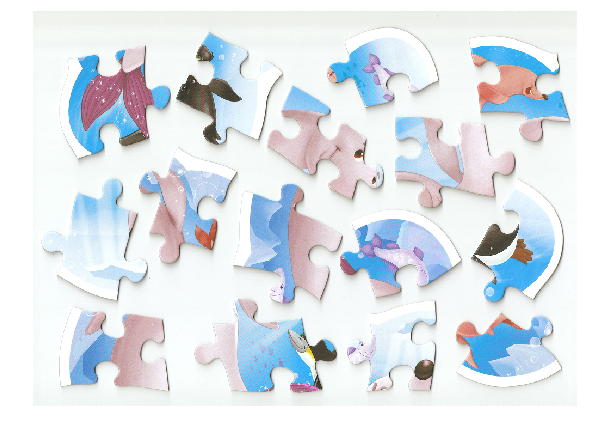

In [5]:
# Load scanned tiles
puzzle = np.array(Image.open('/home/nvidia/Puzzle Solver/puzzle.png').convert('RGBA'))
print(puzzle.shape)
showpic(puzzle)


In the given image, we observe colored tiles against a sky-blue background. In order to manipulate the tiles individually, we need to detect and separate them first. Since the background is monochrome, one approach to achieve this is by using Adaptive Thresholding. By applying the adaptiveThreshold() function to our image, we can effectively separate the tiles from the background.

Additionally, we may choose to use the GaussianBlur() function, which is optional but recommended in this case. This is because some tiles have white edges that blend into the background, creating gaps that need to be filled. The GaussianBlur() function helps to smooth out these edges and ensure a more accurate detection and separation of the tiles.

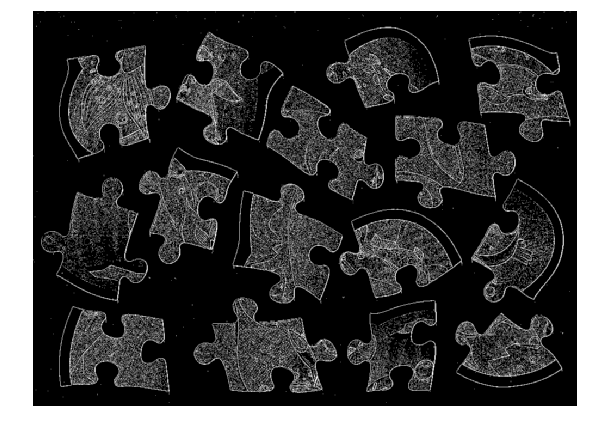

In [6]:
thresh = cv2.cvtColor(puzzle, cv2.COLOR_RGBA2GRAY)
thresh = cv2.adaptiveThreshold(thresh, 255, 0, 1, 3, 3)
thresh = cv2.GaussianBlur(thresh, (3,3), 1)
showpic(thresh)

The current state of the image appears satisfactory. However, in order to perform further operations, we require a clear binary image where each pixel is classified as either a tile or background. To achieve this, we will employ a simple technique using OpenCV's contour detection and fill methods.

To ensure that only the relevant contours are considered, we will sort the detected contours in descending order based on their length. This step helps to suppress any additional contours that may have been formed by other elements in the image, such as paintings or artifacts. In this case, we will manually select the largest contours, as the automation process has been omitted to simplify the code.

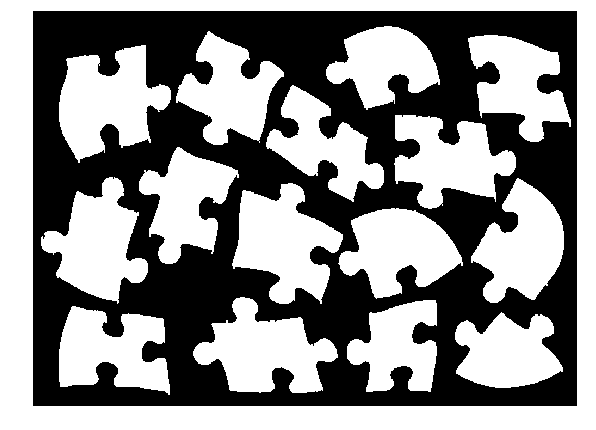

In [7]:
# Find and fill contours
contours, _ = cv2.findContours(thresh, 0, 1)
sorted = sorted([[cnt.shape[0], i] for i, cnt in enumerate(contours)], reverse=True)[:number_of_pieces]

biggest = [contours[s[1]] for s in sorted]
fill = cv2.drawContours(np.zeros(puzzle.shape[:2]), biggest, -1, 255, thickness=cv2.FILLED)
showpic(fill)

The original scanned image of the tiles exhibits ragged borders and protruding spikes caused by shadows. To address this issue, a common approach is to apply median filtering. This technique involves transforming each element in the image to resemble the average style of its surrounding elements. In simpler terms, if all the neighboring elements are short and one element is tall, it will be adjusted to match the shorter height. This helps to suppress the spikes and create smoother borders for the tiles.

After applying the median_filter() function, we further refine the shapes by drawing a black-colored contour around them. This step helps to eliminate shadows and any extra pixels that may have been introduced during the blur operation mentioned earlier. Trimming the shapes in this manner ensures a cleaner representation of the tiles without the unwanted artifacts.

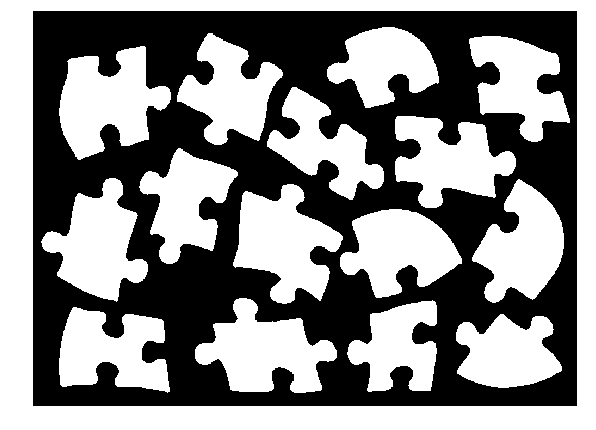

In [8]:
smooth = filters.median_filter(fill.astype('uint8'), size=10)
trim_contours, _ = cv2.findContours(smooth, 0, 1)
cv2.drawContours(smooth, trim_contours, -1, color=0, thickness=1)
showpic(smooth)

With the image now in a binary format, clearly distinguishing between tiles and the background without any halftones, we can proceed to extract the colored tiles one by one. To achieve this, we will superimpose the binary image onto the original image.

To extract each colored tile individually, we can utilize the boundingRect() function, which plays a clever role in detecting the minimal bounding box that encompasses each tile's shape. This function helps us determine the precise coordinates and dimensions of the bounding box, allowing us to cut out the desired tile from the larger image.

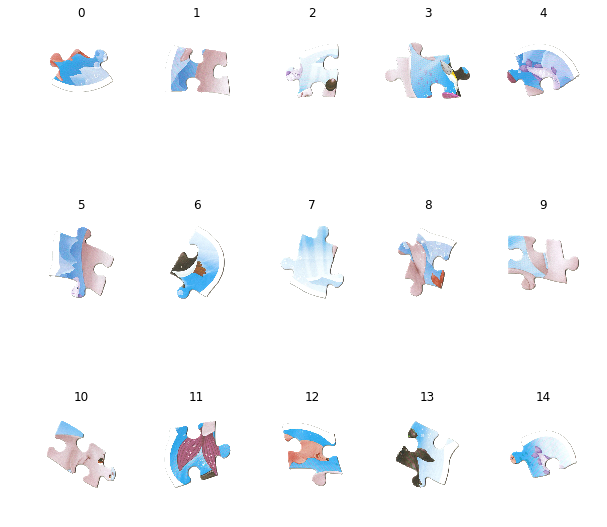

In [10]:
# Split into tiles
contours, _ = cv2.findContours(smooth, 0, 1)

tiles, tile_centers = [], []
for i in range(len(contours)):
  x, y, w, h = cv2.boundingRect(contours[i])
  shape, tile = np.zeros(puzzle.shape[:2]), np.zeros((300,300,4), 'uint8')
  cv2.drawContours(shape, [contours[i]], -1, color=1, thickness=-1)
  shape = (puzzle * shape[:,:,None])[y:y+h, x:x+w, :]
  tile[(300-h)//2:(300-h)//2+h,(300-w)//2:(300-w)//2+w] = shape
  tiles.append(tile)
  tile_centers.append((h//2+y, w//2+x))

showlist(tiles)


The main concept behind the matching process is to take a pair of tiles, analyze their contours to identify similar parts, compare the colors along those parts, and then attempt to align and connect those parts without losing any pixels.

To begin, we rescale our tiles. We place them on a 1400 x 1400 canvas, which serves as the canvas for assembling the entire puzzle. This resizing operation is purely technical and does not hold any hidden significance. It allows us to work with a standardized canvas size for easier manipulation and alignment of the tiles.

In [11]:
# Rescale tiles to assembly format
canvas_tiles = []
for i in range(len(tiles)):
  canvas_tile = np.zeros((1400,1400,4), 'uint8')
  canvas_tile[550:850, 550:850] = tiles[i].copy()
  canvas_tiles.append(canvas_tile)

The matching algorithm relies on four auxiliary functions, all of which are based on basic 2D geometry principles:

getColors(): This function is designed to extract color pixels along the subcontour of an image. It takes every 3 points of the subcontour and calculates two points orthogonal to the subcontour, both inside and outside it, up to a depth of 3 pixels. Since the exact position of the tile is unknown, this approach helps capture the color information. The function converts the colors to the HSV color space and adds them to a list.

putOnAnvil(): This function is a technical step that takes an input image as a NumPy array and applies offset and rotation using methods from the PIL library. It is used to rotate and reposition the canvas tile, aligning its subcontour center with the center of the image for seamless merging with a matching tile.

rotatePoint(): This function is useful for tracking the center of a tile as we move and rotate the puzzle and tiles during assembly or fitting. It helps maintain the correct position of the tile's center throughout the transformations.

reScale(): This function is once again a technical step used to translate point coordinates from the (300, 300) space of the tile image to the (1400, 1400) space of the puzzle canvas. Working in two different coordinate spaces is necessary to save processing time by avoiding unnecessary calculations on zero pixels.

Throughout the code, it is important to keep in mind that OpenCV works in the (x, y) coordinate domain, while other modules use the (y, x) convention. Therefore, there will be a need to constantly swap and flip coordinates to ensure consistency between the different modules.

In [12]:

def getColors(image, subcontour):
  subcontour = np.flip(subcontour)

  colors = []
  for n in range(len(subcontour)-3):
    (y,x) = subcontour[n]
    (y1,x1) = subcontour[n+3]
    h, w = y1 - y, x1 - x
    colors.append(image[y-w, x+h, :3] + image[y+w, x-h, :3])
  colors = np.array(colors, 'uint8').reshape(-1,1,3)
  colors = cv2.cvtColor(colors, cv2.COLOR_RGB2HSV)

  return colors.reshape(-1,3)

def putOnAnvil(arr_img, point, angle, center=(700,700)):
  img = Image.fromarray(arr_img)
  img = ImageChops.offset(img, center[1] - point[1], center[0] - point[0])
  img = img.rotate(angle)
  return np.array(img)

def rotatePoint(point, angle, center=(700,700)):
  dy, dx = center[0]-point[0], point[1]-center[1]
  distance = np.sqrt(np.square(point[0]-center[0]) + np.square(point[1]-center[1]))
  if dx==0: dx = 1
  base = 90*(1-np.sign(dx)) + np.degrees(np.arctan(dy/dx))

  y = round(center[0] - distance * np.sin(np.pi * (base + angle)/180))
  x = round(center[1] + distance * np.cos(np.pi * (base + angle)/180))

  return (y,x)

def reScale(point, position, center=(150,150)):
  cy, cx, angle = position
  if angle!=0: (y, x) = rotatePoint(point, angle, center)
  else: (y, x) = point
  return (y + cy - center[0], x + cx - center[1])


Before we proceed with the matching algorithm, let's gain a clear understanding of some fundamental concepts that will be utilized. These concepts include tiles A and B, their respective subcontours and subcontour centers (pointA and pointB), the bounding rectangle and center of each tile, the minimum area rectangles and their centers (cA and cB), the angles (angleA and angleB), and the classification of subcontours as tab or blank (typepointA and typepointB). Additionally, we have the canvas center referred to as the "anvil" and the nearby subcontour points used for color matching.

Now, let's delve into the matching algorithm itself. Although it may appear complex at first glance, the structure is actually quite straightforward. We begin by extracting the contours of the two tiles using OpenCV's findContours() function. Subsequently, we extract small subcontours from tile A and compare them against small subcontours from tile B. These subcontours are obtained by rolling and slicing the main contour.

The matching algorithm consists of three primary loops: contour matching, color matching, and pre-fitting. Each loop serves a specific purpose and aims to progressively reduce the number of matches by applying various filtering criteria. For instance, contour matching focuses on comparing the shapes of subcontours, while color matching involves comparing color points along the subcontours using the fastdtw() distance metric. The pre-fitting stage attempts to fuse tiles directly by superimposing their subcontour centers, rotating them, and evaluating the resulting metrics.
Throughout the algorithm, it is important to consider the coordinate systems used by different modules. OpenCV operates in the (x, y) coordinate domain, while other modules may use the (y, x) convention. Consequently, coordinate swapping and flipping are necessary to ensure consistency between the modules.

In [13]:
def matchTiles(A, B):

  LENGTH = 160
  PRECISION = 8
  STEP_A = 20
  STEP_B = 7
  MAX_FORM = 0.015
  MAX_COLOR = 8000
  MAX_PIXEL = 0.03
  MAX_FIT = 0.77
  CENTER = round(LENGTH/2)

  tileA, tileB = tiles[A], tiles[B]
  cntA, _ = cv2.findContours(tileA[:,:,3], 0, 1)
  cntB, _ = cv2.findContours(tileB[:,:,3], 0, 1)
  cntA, cntB = cntA[0].reshape(-1,2), cntB[0].reshape(-1,2)
  sumLen = cntA.shape[0] + cntB.shape[0]

  # Contour matching
  form_matches = []
  for i in range(0, cntA.shape[0], STEP_A):

    # subcontour A and its type
    subcA = np.roll(cntA, -i, 0)[:LENGTH]
    pointA = tuple(np.flip(subcA[CENTER]))
    cA, (hA,wA), aA = cv2.minAreaRect(subcA)
    typepointA = np.int0(np.flip(subcA[0] + subcA[-1] - cA))
    typeA = tileA[:,:,3][tuple(typepointA)]
    a = cv2.drawContours(np.zeros((300,300),'uint8'), subcA.reshape(-1,1,2), -1, 255, 1)

    # loop through match subcontours
    for j in range(0, cntB.shape[0], STEP_B):

      # subcontour B and its type
      subcB = np.roll(cntB, -j, 0)[:LENGTH]
      pointB = tuple(np.flip(subcB[CENTER]))
      cB, (hB,wB), aB = cv2.minAreaRect(subcB)
      typepointB = np.int0(np.flip(subcB[0] + subcB[-1] - cB))
      typeB = tileB[:,:,3][tuple(typepointB)]

      # record good form matches
      if typeB != typeA:
        if ((abs(hA-hB) < PRECISION) & (abs(wA-wB) < PRECISION)) or ((abs(hA-wB) < PRECISION) & (abs(wA-hB) < PRECISION)):
          b = cv2.drawContours(np.zeros((300,300),'uint8'), subcB.reshape(-1,1,2), -1, 255, 1)
          fmatch = cv2.matchShapes(a,b,1,0)
          if fmatch < MAX_FORM:
            colinear = True if np.sign(hA-wA) == np.sign(hB-wB) else False
            if colinear:
              codirect = True if (np.sign(typepointA - np.flip(cA)) ==  np.sign(typepointB - np.flip(cB))).all() else False
            else:
              c = np.concatenate([np.sign(typepointA - np.flip(cA)), np.sign(typepointB - np.flip(cB))])
              codirect = True if (abs(np.sum(c[:3])) + abs(np.sum(c[-3:]))) == 4 else False
            if not colinear: aB = aB + 90
            if not codirect: aB = aB + 180
            form_matches.append([(i, j), pointA, pointB, round(aB-aA,4), round(fmatch,4)])

  # Color matching
  color_matches = []
  for n in range(len(form_matches)):
    (i, j), pointA, pointB, angle, fmatch = form_matches[n]

    subcA = np.roll(cntA, -i, 0)[:LENGTH]
    subcB = np.roll(cntB, -j, 0)[:LENGTH]
    colorsA = getColors(tileA, subcA)
    colorsB = getColors(tileB, subcB)

    cmatch = fastdtw(colorsA, np.flip(colorsB, axis=0))[0]
    if cmatch < MAX_COLOR:
      color_matches.append([(i, j), pointA, pointB, angle, fmatch, round(cmatch)])

  # Pre-fitting
  fit_matches = []
  for n in range(len(color_matches)):
    (i, j), pointA, pointB, angle, fmatch, cmatch = color_matches[n]
    a = putOnAnvil(canvas_tiles[A][:,:,3], reScale(pointA, [700,700,0]), 0)
    b = putOnAnvil(canvas_tiles[B][:,:,3], reScale(pointB, [700,700,0]), angle)

    loss = 1 - (np.sum((a+b)>0) / (np.sum(a>0) + np.sum(b>0)))
    contours, _ = cv2.findContours((a+b), 0, 1)
    fit = contours[0].shape[0] / sumLen
    if (loss < MAX_PIXEL) & (fit < MAX_FIT):
      fit_matches.append([(A, B), (i, j), pointA, pointB, angle, fmatch, cmatch, round(loss+fit,4), 0])

  fit_matches.sort(key=lambda n: n[-1])

  return fit_matches

the matching algorithm's parameters will require manual tuning for each puzzle:

LENGTH: This parameter represents the subcontour length, which is approximately equal to the minimum joint length. It should be variable for puzzles with tiles of significantly different sizes.

PRECISION: This parameter serves as a rough filter to eliminate obvious non-matches. It allows for a difference in dimensions between the bounding rectangles of subcontours. A non-zero value is necessary due to the inherent lack of 100% accuracy in image processing.

STEP_A and STEP_B: These parameters determine the shifts used to obtain another subcontour during the matching process. While a step value of 1 would be ideal, it would result in an infinite loop. Therefore, a compromise must be found.

MAX_*: These parameters define the upper limits for various metrics used in the matching algorithm. They depend primarily on the resolution and subcontour length of the puzzle.

The matching algorithm is then executed in a loop for all possible pairs of tiles. The runtime for each pair is approximately 0.5 seconds. While this is acceptable for a puzzle with 105 pairs, larger puzzles with 8192 pairs would take around an hour to complete. To optimize performance for larger puzzles, techniques such as using numba, parallel threads, and algorithmic tricks like early grouping of tiles and pre-assemblies can be employed.

The resulting list of matches contains information about the tile numbers, roll values, subcontour center coordinates, rotation angle, and metrics. If no matches meet the specified limitations, the result list will be empty. It is also possible to miss some matches, as tiles may still lock during the assembly process.

In [14]:
matches = []
for a in range(len(tiles)-1):
  for b in range(a+1,len(tiles)):
    matches.extend(matchTiles(a,b))

# Flip and sort
for n in range(len(matches)):
  pair, ij, pointa, pointb, angle, fmatch, cmatch, fit, lock = matches[n]
  matches.extend([[(pair[1],pair[0]), ij, pointb, pointa, -angle, fmatch, cmatch, fit, lock]])
matches.sort(key=lambda m: (m[0], m[-2]))

The assembly process involves putting together a puzzle by matching and locking tiles. We focus on aligning the centers of the tiles with the center of the canvas and rotating them as needed. This allows us to easily connect the tiles together. We also keep track of the tile centers and angles on the canvas as we assemble the puzzle. This approach simplifies the assembly algorithm and provides an efficient solution for puzzle assembly.

In [15]:
def updateCanvas(canvas, positions, pointA, pointB, angleA, angleB):

  # update records for tiles on canvas
  for N, pos in enumerate(positions):
    if N in canvas:
      new_center = (pos[0] + 700 - pointA[0], pos[1] + 700 - pointA[1])
      new_center = rotatePoint(new_center, angleA)
      new_angle = pos[2] + angleA
      positions[N] = [*new_center, new_angle]

  # append record for the added tile
  canvas.append(B)
  center = rotatePoint((1400 - pointB[0], 1400 - pointB[1]), angleB)
  positions[B] = [*center, angleB]

  return canvas, positions

During the assembly process, we need to filter the correct tiles. To achieve this, we utilize pixel loss control. When we add a new tile to the puzzle, if it overlaps incorrectly and causes a partial loss of color pixels, we assess the extent of this loss. If the pixel loss is below a certain threshold (for example, 10% of the added tile), we accept the tile. However, if the pixel loss exceeds this threshold, it indicates a likely mismatch, and we need to try another tile.

To keep the algorithm simple, we do not include tile replacement. Instead, we limit the number of attempts to assemble the puzzle to a maximum of 15. Additionally, we exit the loop if the number of tiles on the canvas reaches 15. This means that if we place a wrong tile or position a correct tile incorrectly, we cannot go back and redo the placement. However, for this particular puzzle, this level of simplicity is sufficient.

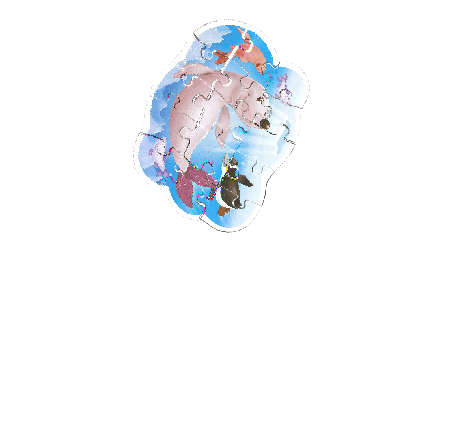

In [16]:
assembly = canvas_tiles[0].copy()
positions = [[0,0,0]]*len(tiles)
positions[0] = [700,700,0]
canvas = [0]
attempts = 0

while (len(canvas) < 15) & (attempts < 15):
  for n in range(len(matches)):

    # take next matching pair
    (A, B), ij, pointA, pointB, angleB, _, _, _, lock = matches[n]
    pointA = reScale(pointA, positions[A])
    pointB = reScale(pointB, (700,700,0))

    if A in canvas:
      angleA = - positions[A][2]
      pre_assembly = putOnAnvil(assembly.copy(), pointA, angleA)

      if B not in canvas:
        newtile = putOnAnvil(canvas_tiles[B], pointB, angleB)

        # fix or pass depending on loss of pixels
        loss = (np.sum(pre_assembly[:,:,3]>0) + np.sum(newtile[:,:,3]>0) -
                np.sum((pre_assembly+newtile)[:,:,3]>0)
                ) / np.sum(newtile[:,:,3]>0)
        if loss < 0.1:
          matches[n][-1] = 1
          assembly = pre_assembly.copy() + newtile.copy()
          canvas, positions = updateCanvas(canvas, positions,
                                           pointA, pointB, angleA, angleB)
  attempts += 1

showpic(assembly)

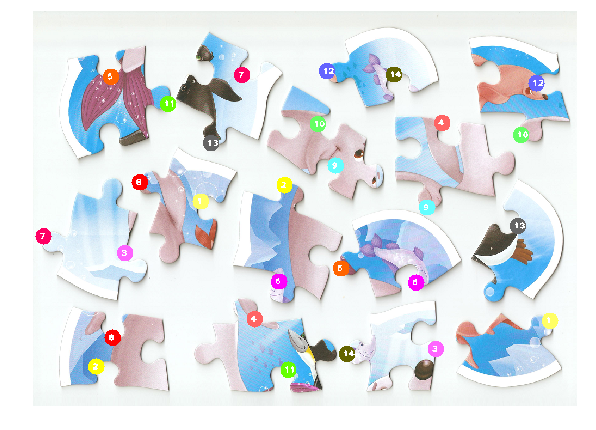

In [17]:
# Mark matches in original image
count = 0
markup = puzzle.copy()
colors = [[r,g,b,255] for r in [255,100,0] for g in [255,100,0] for b in [255,100,0]]

for n in range(len(matches)):
  (A, B), _, pointA, pointB, _, _, _, _, lock = matches[n]
  if lock == 1:
    count += 1
    centerA = (tile_centers[A][1]-(150-pointA[1]), tile_centers[A][0]-(150-pointA[0]))
    centerB = (tile_centers[B][1]-(150-pointB[1]), tile_centers[B][0]-(150-pointB[0]))
    cv2.circle(markup, centerA, 15, colors[count], -1)
    cv2.circle(markup, centerB, 15, colors[count], -1)
    cv2.putText(markup, str(count), (centerA[0]-7,centerA[1]+5), 1, 1, [255,255,255,255], 2)
    cv2.putText(markup, str(count), (centerB[0]-7,centerB[1]+5), 1, 1, [255,255,255,255], 2)

showpic(markup)